## 3 Grid Search

### 3.1 Preparation

##### Library Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

We have stored our custom transformations as a library and import them here. This makes the code slimmer and allows us to use multiple cores in Windows environments.

In [3]:
from day_18_challenge_pipeline_classes import ConvertStringDateToYear, ConvertZeroToN, MergeColumns
from day_18_challenge_pipeline_classes import ColumnSelector, ImputeValue
from day_18_challenge_pipeline_classes import compare_predictions

In [4]:
import warnings
warnings.filterwarnings('ignore') # seaborn shows a lot of ugly warnings, let's suppress this for the analysis part

##### Data Import

Here we replicate the import and row removal of the pipeline build step.

In [5]:
df_train = pd.read_csv('data/dc_housing/DC_Properties_training.csv', index_col=0, low_memory=False)

df_train = df_train.dropna(subset=["PRICE"])

x_train = df_train.drop('PRICE', axis=1)
y_train = df_train.loc[:,['PRICE']]

We now also load the test data set as we are going to need it in the final evaluation. Here we drop only the rows with n/a values in the target column ```PRICE``` as we couldn't compare the predictions with their true values otherwise.

In [6]:
df_test = pd.read_csv('data/dc_housing/holdout_test_data.csv', index_col=0, low_memory=False)
df_test = df_test[~np.isnan(df_test['PRICE'])]

x_test = df_test.drop('PRICE', axis=1)
y_test = df_test.loc[:,['PRICE']]

Again, we replicate the column seletors from pipeline bild step.

In [7]:
cols_num = ['BATHRM','HF_BATHRM','ROOMS','BEDRM','FIREPLACES','YEAR','AYB','EYB','GBA','LANDAREA']
cols_ord = ['GRADE','HEAT','ZIPCODE','ASSESSMENT_NBHD', 'CENSUS_TRACT']
cols_cat = ['AC','SOURCE','QUALIFIED']

cols_all = cols_num + cols_ord + cols_cat

##### Processing Pipeline Definition

...and finally the pipeline we've built. Now we are ready to try out different estimators and perform a grid search across the respective hyperparameters.

In [8]:
processing_pipeline = make_pipeline(
    
    MergeColumns('GBA', 'LIVING_GBA'),
    ImputeValue('AYB', 1940),
    ConvertZeroToN('AC'),
    ConvertStringDateToYear('SALEDATE'),
    ImputeValue('YEAR', 2004),
    make_union(
        make_pipeline(ColumnSelector(cols_num),
        ),
        make_pipeline(ColumnSelector(cols_ord),
                      OrdinalEncoder()
        ),
        make_pipeline(ColumnSelector(cols_cat),
                      OneHotEncoder()
        )
    )
)

### 3.1 Random Forest

In [9]:
pipeline_rf = (make_pipeline(processing_pipeline, RandomForestRegressor()))

In [10]:
n_estimators = [100, 200, 500, 1000]                       # number of trees in random forest
max_features = [5, 10, 20]                                 # number of features to consider at every split
max_depth = [int(x) for x in np.linspace(5, 110, num = 4)] # maximum number of levels in tree
max_depth.append(None)

grid_rf = {'randomforestregressor__n_estimators': n_estimators,
           'randomforestregressor__max_features': max_features,
           'randomforestregressor__max_depth': max_depth}

In [11]:
n_estimators = [100]                       # number of trees in random forest
max_features = [20]                                 # number of features to consider at every split
max_depth = [30] # maximum number of levels in tree

grid_rf_fast = {'randomforestregressor__n_estimators': n_estimators,
           'randomforestregressor__max_features': max_features,
           'randomforestregressor__max_depth': max_depth}

In [12]:
clf_rf = GridSearchCV(pipeline_rf, grid_rf, n_jobs=-1, verbose=True, scoring='neg_mean_absolute_error')
clf_rf.fit(x_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 308.7min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('mergecolumns', <day_18_challenge_pipeline_classes.MergeColumns object at 0x000001AE5CB8D048>), ('imputevalue-1', <day_18_challenge_pipeline_classes.ImputeValue object at 0x000001AE5CB8CF60>), ('convertzeroton', <day_18_challenge_pipeline_classe...s='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'randomforestregressor__n_estimators': [100, 200, 500, 1000], 'randomforestregressor__max_features': [5, 10, 20], 'randomforestregressor__max_depth': [5, 40, 75, 110, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=True)

RMSE Lazy Predictor 7033624.958887028
MAE Lazy Predictor 944466.509408971
R^2 Lazy Predictor 0.0

RMSE 1104695.7128430633
MAE 195570.18600621258
R^2 0.975332398598202

RMSE Improvement: 5928929.246043964
MAE Inprovement: 748896.3234027583
R^2 Improvement: 0.975332398598202


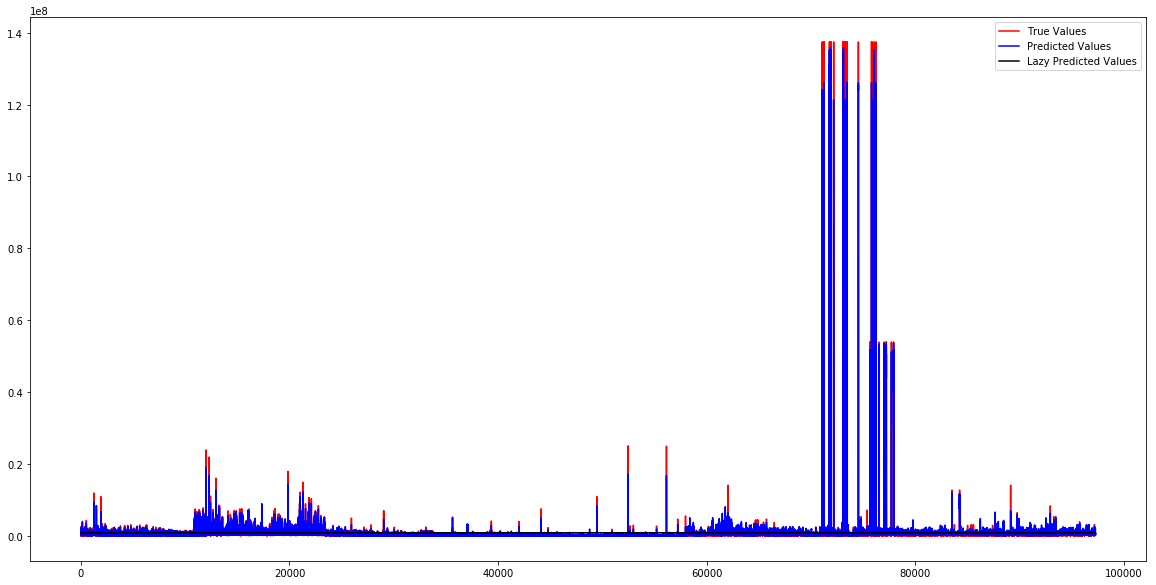

In [13]:
pred_rf_train = compare_predictions(x_train, y_train, clf_rf, y_train['PRICE'].mean())

### 3.2 Gradient Boosting

In [14]:
pipeline_gb = (make_pipeline(processing_pipeline, GradientBoostingRegressor()))
pipeline_gb.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('mergecolumns', <day_18_challenge_pipeline_classes.MergeColumns object at 0x000001AE5CB8D048>), ('imputevalue-1', <day_18_challenge_pipeline_classes.ImputeValue object at 0x000001AE5CB8CF60>), ('convertzeroton', <day_18_challenge_pipeline_classe...one, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False))])

In [15]:
# Preparing grid search
# Supported parameters for GradientBoostingRegressor
# ---------------------
# loss='ls'
# learning_rate=0.1
# n_estimators=100
# subsample=1.0
# criterion='friedman_mse'
# min_samples_split=2
# min_samples_leaf=1
# min_weight_fraction_leaf=0.0
# max_depth=3
# min_impurity_decrease=0.0
# min_impurity_split=None
# init=None
# random_state=None
# max_features=None
# alpha=0.9
# verbose=0
# max_leaf_nodes=None
# warm_start=False
# presort='auto'
# validation_fraction=0.1
# n_iter_no_change=None
# tol=0.0001

learning_rate = [0.01, 0.04, 0.1]
n_estimators = [100, 500, 1000]
min_samples_split = [2, 3, 4]
min_samples_leaf = [1, 2]
max_depth = [3, 5, 6]

grid_gb = {'gradientboostingregressor__learning_rate': learning_rate,
           'gradientboostingregressor__n_estimators': n_estimators,
           'gradientboostingregressor__min_samples_split': min_samples_split,
           'gradientboostingregressor__min_samples_leaf': min_samples_leaf,
           'gradientboostingregressor__max_depth': max_depth}

In [16]:
learning_rate = [0.01]
n_estimators = [100]
min_samples_split = [4]
min_samples_leaf = [2]
max_depth = [6]

grid_gb_fast = {'gradientboostingregressor__learning_rate': learning_rate,
           'gradientboostingregressor__n_estimators': n_estimators,
           'gradientboostingregressor__min_samples_split': min_samples_split,
           'gradientboostingregressor__min_samples_leaf': min_samples_leaf,
           'gradientboostingregressor__max_depth': max_depth}

In [17]:
clf_gb = GridSearchCV(pipeline_gb, grid_gb, n_jobs=1, verbose=True, scoring='r2')
clf_gb.fit(x_train, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [ ]:
pred_gb_train = compare_predictions(x_train, y_train, clf_gb, y_train['PRICE'].mean())

### 3.3 Ada Boost

In [ ]:
pipeline_ab = (make_pipeline(processing_pipeline, AdaBoostRegressor()))
pipeline_ab.fit(x_train, y_train)

In [ ]:
# Preparing grid search
# Supported parameters for AdaBoostRegressor
# ---------------------
# base_estimator=None
# n_estimators=50
# learning_rate=1.0
# loss='linear'
# random_state=None

learning_rate = [0.01, 0.04, 0.1]
n_estimators = [100, 500, 1000]

grid_ab = {'adaboostregressor__learning_rate': learning_rate,
           'adaboostregressor__n_estimators': n_estimators}

In [ ]:
learning_rate = [0.01, 0.1]
n_estimators = [500]

grid_ab_fast = {'adaboostregressor__learning_rate': learning_rate,
           'adaboostregressor__n_estimators': n_estimators}

In [ ]:
clf_ab = GridSearchCV(pipeline_ab, grid_ab, n_jobs=1, verbose=True, scoring='r2')
clf_ab.fit(x_train, y_train)

In [ ]:
pred_ab_train = compare_predictions(x_train, y_train, clf_ab, y_train['PRICE'].mean())

### 3.4 Bagging

In [ ]:
pipeline_br = (make_pipeline(processing_pipeline, BaggingRegressor()))
pipeline_br.fit(x_train, y_train)

In [ ]:
# Preparing grid search
# Supported parameters for BaggingRegressor
# ---------------------
# base_estimator=None
# n_estimators=10
# max_samples=1.0
# max_features=1.0
# bootstrap=True
# bootstrap_features=False
# oob_score=False
# warm_start=False
# n_jobs=None
# random_state=None
# verbose=0

n_estimators = [10, 50, 100, 200]
max_samples = [2, 4, 8]
max_features = [1, 5, 10, 20]

grid_br = {'baggingregressor__n_estimators': n_estimators,
           'baggingregressor__max_samples': max_samples,
           'baggingregressor__max_features': max_features}

In [ ]:
n_estimators = [10]
max_samples = [2]
max_features = [1, 10]

grid_br_fast = {'baggingregressor__n_estimators': n_estimators,
           'baggingregressor__max_samples': max_samples,
           'baggingregressor__max_features': max_features}

In [ ]:
clf_br = GridSearchCV(pipeline_br, grid_br, n_jobs=1, verbose=True, scoring='r2')
clf_br.fit(x_train, y_train)

In [ ]:
pred_br_train = compare_predictions(x_train, y_train, clf_br, y_train['PRICE'].mean())